In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import scipy.stats as sps

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [4]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [5]:
List = h5py.File('SatelliteList_V2_withAngles.h5', 'r')
List.keys()

<KeysViewHDF5 ['CosCen', 'CosVel', 'LZ_L', 'SatelliteCentral', 'SatelliteList']>

In [6]:
satlist = List['SatelliteList'][()]

In [7]:
numberlist, zlist = [], []

for s in satlist:
    uniqueID = int(128*1e6+s)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    nuT = []
    zs = []
    for mm in mtree:
        snap, ffT = split_unique_id(int(mm))
        offStar = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][ffT].astype('int')
        zT = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        zs.append(zT)
        if offStar[0]>=0 and offStar[1]>=0:
            nuT.append(offStar[1]-offStar[0])
        else:
            nuT.append(0.)
            
    numberlist.append(np.array(nuT))
    zlist.append(np.array(zs))

numberlist = np.array(numberlist)
zlist = np.array(zlist)

In [8]:
nm = 0

for n, z in zip(numberlist, zlist):
    nn = n.size
    if nn>nm:
        nm = nn
        zT = z

In [9]:
nm, zT

(99,
 array([2.22044605e-16, 2.22044605e-16, 1.16323691e-02, 2.34529576e-02,
        3.54671017e-02, 4.76803722e-02, 6.00985761e-02, 7.27278089e-02,
        8.55744153e-02, 9.86450693e-02, 1.11946745e-01, 1.25486754e-01,
        1.39272749e-01, 1.53312783e-01, 1.67615301e-01, 1.82189180e-01,
        1.97043732e-01, 2.12188790e-01, 2.27634677e-01, 2.43392258e-01,
        2.59473023e-01, 2.75889083e-01, 2.92653186e-01, 3.09778865e-01,
        3.27280376e-01, 3.45172835e-01, 3.63472248e-01, 3.82195590e-01,
        4.01360855e-01, 4.20987181e-01, 4.41094881e-01, 4.61705611e-01,
        4.82842405e-01, 5.04529855e-01, 5.26794201e-01, 5.49663484e-01,
        5.73167723e-01, 5.97339064e-01, 6.22212005e-01, 6.47823588e-01,
        6.74213684e-01, 7.01425203e-01, 7.29504462e-01, 7.58501507e-01,
        7.88470444e-01, 8.19469998e-01, 8.51563899e-01, 8.84821496e-01,
        9.19318348e-01, 9.55137018e-01, 9.92367868e-01, 1.03111004e+00,
        1.07147251e+00, 1.11357545e+00, 1.15755164e+00, 1.2

In [10]:
count, med = np.zeros(nm), np.zeros(nm)

In [11]:
for n in numberlist:
    nn = n.size
    count[:nn] = count[:nn] + 1
    med[:nn] = med[:nn] + n

In [12]:
count

array([94., 94., 94., 94., 94., 94., 93., 93., 93., 93., 91., 91., 91.,
       91., 91., 91., 91., 91., 91., 91., 91., 91., 91., 91., 91., 91.,
       91., 91., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90.,
       90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 90., 89.,
       89., 89., 89., 89., 89., 89., 89., 89., 89., 89., 89., 89., 89.,
       89., 89., 89., 89., 89., 89., 89., 89., 89., 89., 89., 89., 89.,
       89., 89., 89., 89., 89., 89., 88., 88., 88., 88., 88., 86., 83.,
       81., 79., 79., 74., 64., 56., 44., 41.])

In [13]:
med = med/count

In [14]:
std = np.zeros(nm)

for n in numberlist:
    nn = n.size
    std[:nn] = std[:nn] + (n-med[:nn])**2.
    
std = np.sqrt(std/(count-1.))

Text(0.5, 0, 'z')

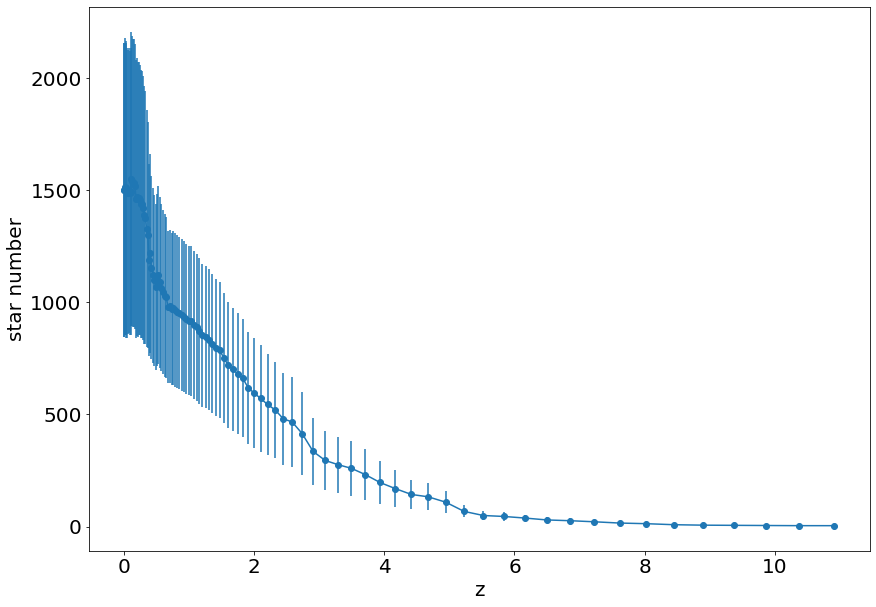

In [15]:
pl.figure(figsize=(14, 10))

pl.errorbar(zT, med, yerr=std/np.sqrt(count), marker='o')

pl.ylabel('star number')
pl.xlabel('z')

In [16]:
i100, i1000 = [], []
j = 0

for n in numberlist:
    if n[0]>100:
        i100.append(j)
    if n[0]>1000:
        i1000.append(j)
    j += 1
    
i100, i1000 = np.array(i100), np.array(i1000)

In [17]:
i100.size, i1000.size

(37, 15)

In [18]:
# with h5py.File('SatelliteList_V2_withAngles_n100.h5', 'w') as f:
#     f.create_dataset('SatelliteList', data=List['SatelliteList'][i100])
#     f.create_dataset('SatelliteCentral', data=List['SatelliteCentral'][i100])
#     f.create_dataset('CosCen', data=List['CosCen'][i100])
#     f.create_dataset('CosVel', data=List['CosVel'][i100])
#     f.create_dataset('LZ_L', data=List['LZ_L'][i100])

In [19]:
# with h5py.File('SatelliteList_V2_withAngles_n1000.h5', 'w') as f:
#     f.create_dataset('SatelliteList', data=List['SatelliteList'][i1000])
#     f.create_dataset('SatelliteCentral', data=List['SatelliteCentral'][i1000])
#     f.create_dataset('CosCen', data=List['CosCen'][i1000])
#     f.create_dataset('CosVel', data=List['CosVel'][i1000])
#     f.create_dataset('LZ_L', data=List['LZ_L'][i1000])

In [20]:
# and the distributions

CosC, CosV = List['CosCen'], List['CosVel']

CosC100, CosV100 = CosC[i100], CosV[i100]
CosC1000, CosV1000 = CosC[i1000], CosV[i1000]

Text(0, 0.5, 'number of galaxies')

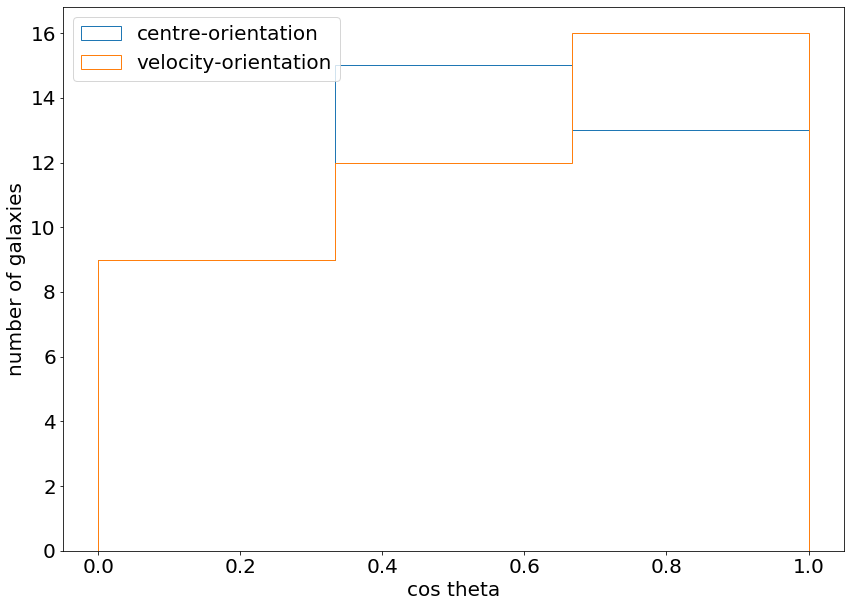

In [21]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC100), label='centre-orientation', histtype='step', range=(0,1.), bins=3)
pl.hist(np.abs(CosV100), label='velocity-orientation', histtype='step', range=(0,1.), bins=3)

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('number of galaxies')

Text(0, 0.5, 'number of galaxies')

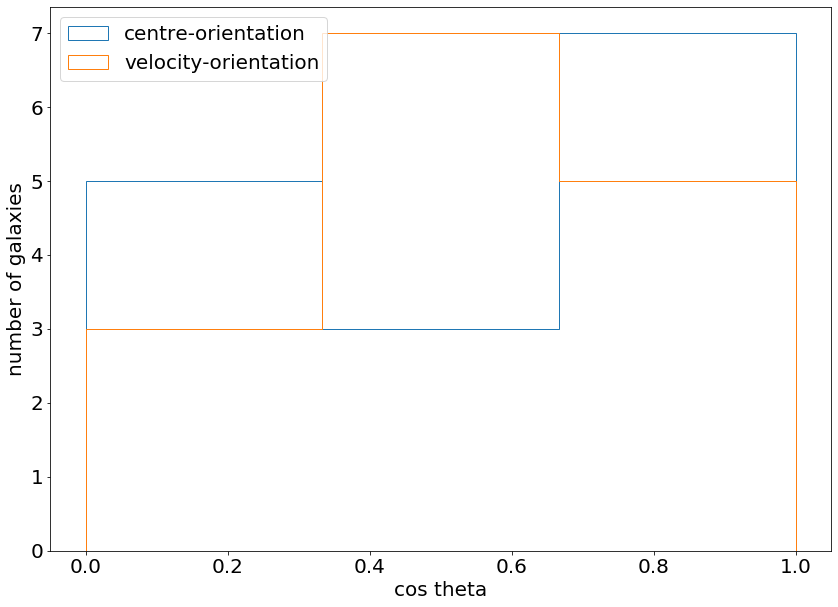

In [22]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC1000), label='centre-orientation', histtype='step', range=(0,1.), bins=3)
pl.hist(np.abs(CosV1000), label='velocity-orientation', histtype='step', range=(0,1.), bins=3)

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('number of galaxies')

In [23]:
# and by radius
sat100, cen100 = List['SatelliteList'][i100], List['SatelliteCentral'][i100]
sat1000, cen1000 = List['SatelliteList'][i1000], List['SatelliteCentral'][i1000]

In [24]:
# I need radius to this things
raddd100 = []

for ss, cc in zip(sat100, cen100):
    cenGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    cenBGG = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    grou = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    R200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][grou]
    
    dist = cenGal-cenBGG
    dd = np.sqrt(np.sum(dist**2.))
    dd = dd/R200
    
    raddd100.append(dd)
    
raddd100 = np.array(raddd100)

raddd1000 = []

for ss, cc in zip(sat1000, cen1000):
    cenGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    cenBGG = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    grou = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    R200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][grou]
    
    dist = cenGal-cenBGG
    dd = np.sqrt(np.sum(dist**2.))
    dd = dd/R200
    
    raddd1000.append(dd)
    
raddd1000 = np.array(raddd1000)

In [25]:
ir100 = np.where(raddd100>0.5)
ir1000 = np.where(raddd1000>0.5)

CosC100R, CosV100R = CosC100[ir100], CosV100[ir100]
CosC1000R, CosV1000R = CosC1000[ir1000], CosV1000[ir1000]

Text(0, 0.5, 'normalized density')

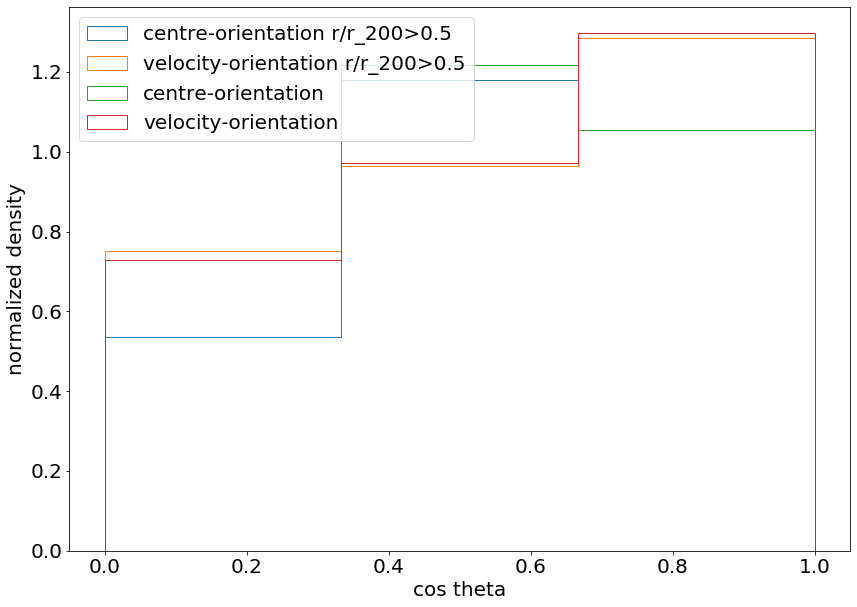

In [26]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC100R), label='centre-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, density=True)
pl.hist(np.abs(CosV100R), label='velocity-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, density=True)

pl.hist(np.abs(CosC100), label='centre-orientation', histtype='step', range=(0,1.), bins=3, density=True)
pl.hist(np.abs(CosV100), label='velocity-orientation', histtype='step', range=(0,1.), bins=3, density=True)

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('normalized density')

Text(0, 0.5, 'normalized density')

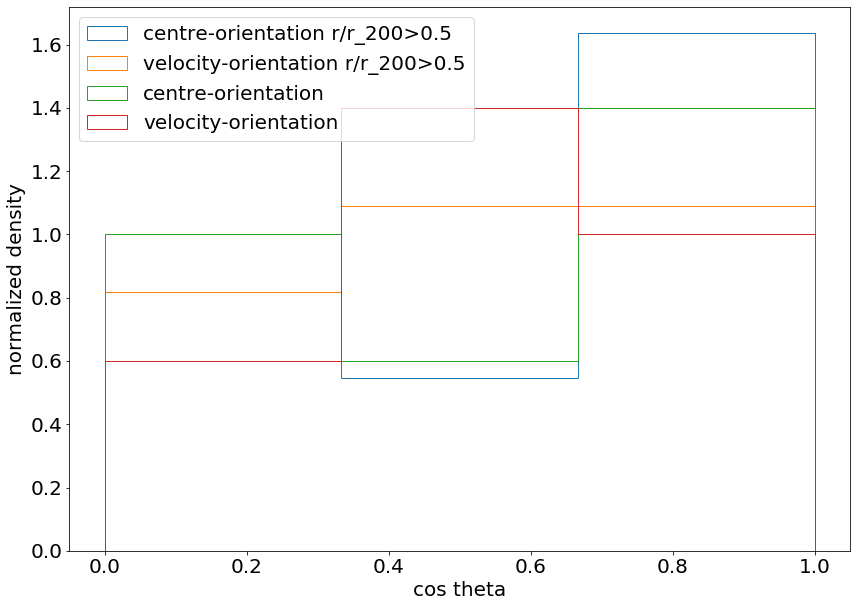

In [27]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC1000R), label='centre-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, density=True)
pl.hist(np.abs(CosV1000R), label='velocity-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, density=True)

pl.hist(np.abs(CosC1000), label='centre-orientation', histtype='step', range=(0,1.), bins=3, density=True)
pl.hist(np.abs(CosV1000), label='velocity-orientation', histtype='step', range=(0,1.), bins=3, density=True)

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('normalized density')

In [28]:
# bootstrap!! because yes, bootstrap

n = 10000 # i guees is ok with that

dataCR = np.zeros((3,n))
dataVR = np.zeros((3,n))

dataC = np.zeros((3,n))
dataV = np.zeros((3,n))

for i in range(n):
    CosCR = np.random.choice(CosC1000R, CosC1000R.size)
    CosVR = np.random.choice(CosV1000R, CosV1000R.size)
    
    CosC = np.random.choice(CosC1000, CosC1000.size)
    CosV = np.random.choice(CosV1000, CosV1000.size)
    
    valueCR, edge, bbb = sps.binned_statistic(np.abs(CosCR), np.abs(CosCR), statistic='count', bins=3, range=(0.,1.))
    valueVR, edge, bbb = sps.binned_statistic(np.abs(CosVR), np.abs(CosVR), statistic='count', bins=3, range=(0.,1.))
    
    valueC, edge, bbb = sps.binned_statistic(np.abs(CosC), np.abs(CosC), statistic='count', bins=3, range=(0.,1.))
    valueV, edge, bbb = sps.binned_statistic(np.abs(CosV), np.abs(CosV), statistic='count', bins=3, range=(0.,1.))
    
    dataCR[:,i] = valueCR
    dataVR[:,i] = valueVR
    
    dataC[:,i] = valueC
    dataV[:,i] = valueV
    
valCR = np.array([np.mean(dataCR[0]), np.mean(dataCR[1]), np.mean(dataCR[2])])
errCR = np.array([np.std(dataCR[0]), np.std(dataCR[1]), np.std(dataCR[2])])

valVR = np.array([np.mean(dataVR[0]), np.mean(dataVR[1]), np.mean(dataVR[2])])
errVR = np.array([np.std(dataVR[0]), np.std(dataVR[1]), np.std(dataVR[2])])

valC = np.array([np.mean(dataC[0]), np.mean(dataC[1]), np.mean(dataC[2])])
errC = np.array([np.std(dataC[0]), np.std(dataC[1]), np.std(dataC[2])])

valV = np.array([np.mean(dataV[0]), np.mean(dataV[1]), np.mean(dataV[2])])
errV = np.array([np.std(dataV[0]), np.std(dataV[1]), np.std(dataV[2])])

xs = (edge[:-1]+edge[1:])*.5

Text(0, 0.5, 'number of galaxies')

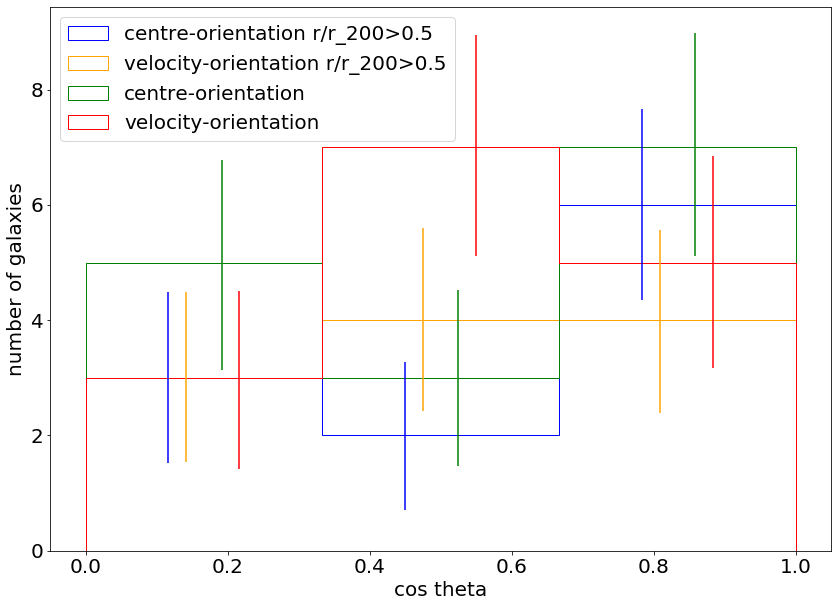

In [29]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC1000R), label='centre-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='blue')
pl.errorbar(xs-0.05, valCR, yerr=errCR, ls=' ', color='blue')

pl.hist(np.abs(CosV1000R), label='velocity-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='orange')
pl.errorbar(xs-0.025, valVR, yerr=errVR, ls=' ', color='orange')

pl.hist(np.abs(CosC1000), label='centre-orientation', histtype='step', range=(0,1.), bins=3, color='green')
pl.errorbar(xs+0.025, valC, yerr=errC, ls=' ', color='green')

pl.hist(np.abs(CosV1000), label='velocity-orientation', histtype='step', range=(0,1.), bins=3, color='red')
pl.errorbar(xs+0.05, valV, yerr=errV, ls=' ', color='red')

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('number of galaxies')

In [30]:
# bootstrap!! because yes, bootstrap

n = 10000 # i guees is ok with that

dataCR = np.zeros((3,n))
dataVR = np.zeros((3,n))

dataC = np.zeros((3,n))
dataV = np.zeros((3,n))

for i in range(n):
    CosCR = np.random.choice(CosC100R, CosC100R.size)
    CosVR = np.random.choice(CosV100R, CosV100R.size)
    
    CosC = np.random.choice(CosC100, CosC100.size)
    CosV = np.random.choice(CosV100, CosV100.size)
    
    valueCR, edge, bbb = sps.binned_statistic(np.abs(CosCR), np.abs(CosCR), statistic='count', bins=3, range=(0.,1.))
    valueVR, edge, bbb = sps.binned_statistic(np.abs(CosVR), np.abs(CosVR), statistic='count', bins=3, range=(0.,1.))
    
    valueC, edge, bbb = sps.binned_statistic(np.abs(CosC), np.abs(CosC), statistic='count', bins=3, range=(0.,1.))
    valueV, edge, bbb = sps.binned_statistic(np.abs(CosV), np.abs(CosV), statistic='count', bins=3, range=(0.,1.))
    
    dataCR[:,i] = valueCR
    dataVR[:,i] = valueVR
    
    dataC[:,i] = valueC
    dataV[:,i] = valueV
    
valCR100 = np.array([np.mean(dataCR[0]), np.mean(dataCR[1]), np.mean(dataCR[2])])
errCR100 = np.array([np.std(dataCR[0]), np.std(dataCR[1]), np.std(dataCR[2])])

valVR100 = np.array([np.mean(dataVR[0]), np.mean(dataVR[1]), np.mean(dataVR[2])])
errVR100 = np.array([np.std(dataVR[0]), np.std(dataVR[1]), np.std(dataVR[2])])

valC100 = np.array([np.mean(dataC[0]), np.mean(dataC[1]), np.mean(dataC[2])])
errC100 = np.array([np.std(dataC[0]), np.std(dataC[1]), np.std(dataC[2])])

valV100 = np.array([np.mean(dataV[0]), np.mean(dataV[1]), np.mean(dataV[2])])
errV100 = np.array([np.std(dataV[0]), np.std(dataV[1]), np.std(dataV[2])])

xs = (edge[:-1]+edge[1:])*.5

Text(0, 0.5, 'number of galaxies')

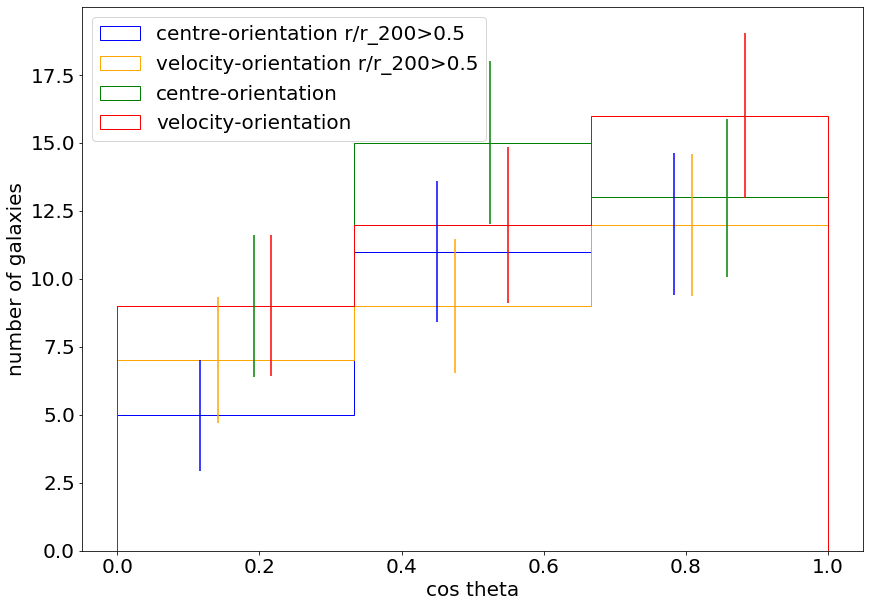

In [31]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC100R), label='centre-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='blue')
pl.errorbar(xs-0.05, valCR100, yerr=errCR100, ls=' ', color='blue')

pl.hist(np.abs(CosV100R), label='velocity-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='orange')
pl.errorbar(xs-0.025, valVR100, yerr=errVR100, ls=' ', color='orange')

pl.hist(np.abs(CosC100), label='centre-orientation', histtype='step', range=(0,1.), bins=3, color='green')
pl.errorbar(xs+0.025, valC100, yerr=errC100, ls=' ', color='green')

pl.hist(np.abs(CosV100), label='velocity-orientation', histtype='step', range=(0,1.), bins=3, color='red')
pl.errorbar(xs+0.05, valV100, yerr=errV100, ls=' ', color='red')

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('number of galaxies')

In [32]:
CosC

array([ 0.62486712,  0.07483519, -0.77056664,  0.94160027,  0.43568094,
        0.51203443,  0.75251846, -0.96170475, -0.53584393,  0.29402649,
        0.42992421,  0.43331846, -0.34053473,  0.42992421,  0.69231843,
       -0.91167217, -0.78211055,  0.32247475, -0.29847823,  0.14674266,
       -0.78211055, -0.07686486, -0.29814695,  0.14674266,  0.87680385,
        0.75251846,  0.87936818,  0.51203443, -0.53584393, -0.37308653,
       -0.87957373,  0.97795123, -0.37308653, -0.77056664, -0.34053473,
       -0.87957373, -0.87957373])

In [33]:
uno, dos, tres = sps.binned_statistic(np.abs(CosCR), np.abs(CosCR), statistic='count', bins=3, range=(0.,1.))

In [34]:
# ok, randomize the thing via, idk, i can take each of this and put a random center

def getAnglesRand(gal):
    offGas = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    RotMass = sim['SnapNumber_128/SubGroups/PartType4/RotationMatrix'][gal]
    cenGas = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
    RotII = RotMass.T
    R = np.array([0., 0., 1.])
    R_rot = np.dot(RotII, R.T).T
    
    velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
#     cenGro = sim['SnapNumber_128/SubGroups/SubGroupPos'][centre]
#     velGro = sim['SnapNumber_128/SubGroups/SubGroupVel'][centre]
    boxsize = sim['SnapNumber_128/Header/BoxSize'][()]
    cenGro = np.random.random(size=3)*boxsize
  
    vecCen = cenGro - cenGas
   # vecVel = velGal - velGro
    vecVel = np.random.random(size=3)
    
    vecCenN = vecCen/np.sqrt(np.sum(vecCen**2.))
    vecVelN = vecVel/np.sqrt(np.sum(vecVel**2.))
    
    # and cosines
    cosCen = np.dot(R_rot, vecCenN)
    cosVel = np.dot(R_rot, vecVelN)
    
    Ls = sim['SnapNumber_128/PartType4/SpecificAngularMomentum'][offGas[0]:offGas[1]]
    Lz = Ls[:,2]
    L = np.sqrt(Ls[:,0]**2+Ls[:,1]**2+Ls[:,2]**2)
    LzL = Lz/L
    
    ii = np.where(np.isnan(LzL)==False)
    LzL = LzL[ii]
    
    LzM = np.mean(LzL)
    
    return cosCen, cosVel, LzM

In [35]:
cosRan100, cosRanV100 = [], []

for ss in zip(sat100[ir100]):
    cc, cv, crap = getAnglesRand(ss)
    cosRan100.append(cc)
    cosRanV100.append(cv)    

<ipython-input-34-5046e591f208>:31: RuntimeWarning: invalid value encountered in true_divide
  LzL = Lz/L


In [36]:
cosRan1000, cosRanV1000 = [], []

for ss in zip(sat1000[ir1000]):
    cc, cv, crap = getAnglesRand(ss)
    cosRan1000.append(cc)
    cosRanV1000.append(cv)    

<ipython-input-34-5046e591f208>:31: RuntimeWarning: invalid value encountered in true_divide
  LzL = Lz/L


In [37]:
cosRan100, cosRanV100, cosRan1000, cosRanV1000 = np.array(cosRan100), np.array(cosRanV100), np.array(cosRan1000), np.array(cosRanV1000) 

In [38]:
# and boostrap this stuff

n = 10000 # i guees is ok with that

ranC100 = np.zeros((3,n))
ranC1000 = np.zeros((3,n))

for i in range(n):
    CosC1 = np.random.choice(cosRan100, cosRan100.size)
    CosC2 = np.random.choice(cosRan1000, cosRan1000.size)
    
    valueC1, edge, bbb = sps.binned_statistic(np.abs(CosC1), np.abs(CosC1), statistic='count', bins=3, range=(0.,1.))
    valueC2, edge, bbb = sps.binned_statistic(np.abs(CosC2), np.abs(CosC2), statistic='count', bins=3, range=(0.,1.))
    
    ranC100[:,i] = valueC1
    ranC1000[:,i] = valueC2
    
valRan100 = np.array([np.mean(ranC100[0]), np.mean(ranC100[1]), np.mean(ranC100[2])])
errRan100 = np.array([np.std(ranC100[0]), np.std(ranC100[1]), np.std(ranC100[2])])

valRan1000 = np.array([np.mean(ranC1000[0]), np.mean(ranC1000[1]), np.mean(ranC1000[2])])
errRan1000 = np.array([np.std(ranC1000[0]), np.std(ranC1000[1]), np.std(ranC1000[2])])

Text(0, 0.5, 'number of galaxies')

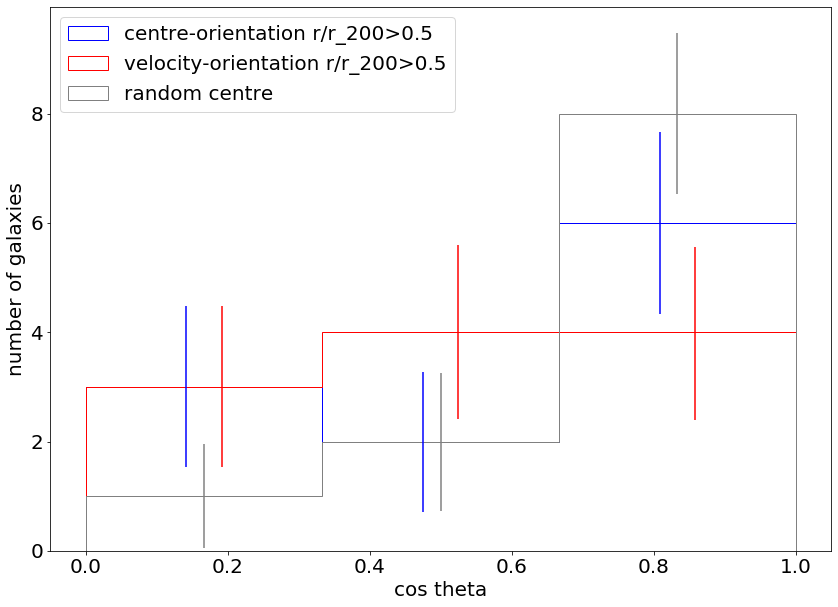

In [39]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC1000R), label='centre-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='blue')
pl.errorbar(xs-0.025, valCR, yerr=errCR, ls=' ', color='blue')

pl.hist(np.abs(CosV1000R), label='velocity-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='red')
pl.errorbar(xs+0.025, valVR, yerr=errVR, ls=' ', color='red')

pl.hist(np.abs(cosRan1000), label='random centre', histtype='step', range=(0,1.), bins=3, color='grey')
pl.errorbar(xs, valRan1000, yerr=errRan1000, ls=' ', color='grey')

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('number of galaxies')

Text(0, 0.5, 'number of galaxies')

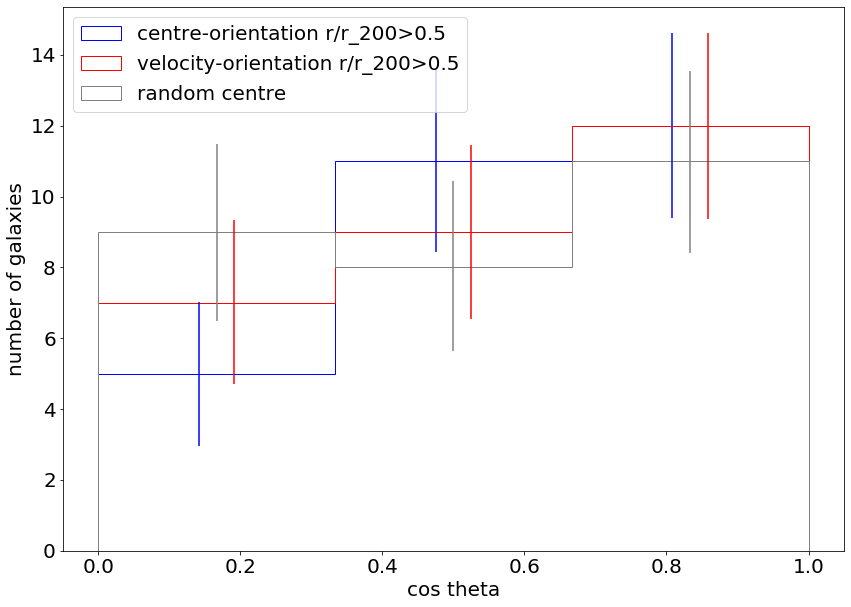

In [40]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC100R), label='centre-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='blue')
pl.errorbar(xs-0.025, valCR100, yerr=errCR100, ls=' ', color='blue')

pl.hist(np.abs(CosV100R), label='velocity-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='red')
pl.errorbar(xs+0.025, valVR100, yerr=errVR100, ls=' ', color='red')

pl.hist(np.abs(cosRan100), label='random centre', histtype='step', range=(0,1.), bins=3, color='grey')
pl.errorbar(xs, valRan100, yerr=errRan100, ls=' ', color='grey')

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('number of galaxies')

Text(0.5, 0, 'Number of star particles')

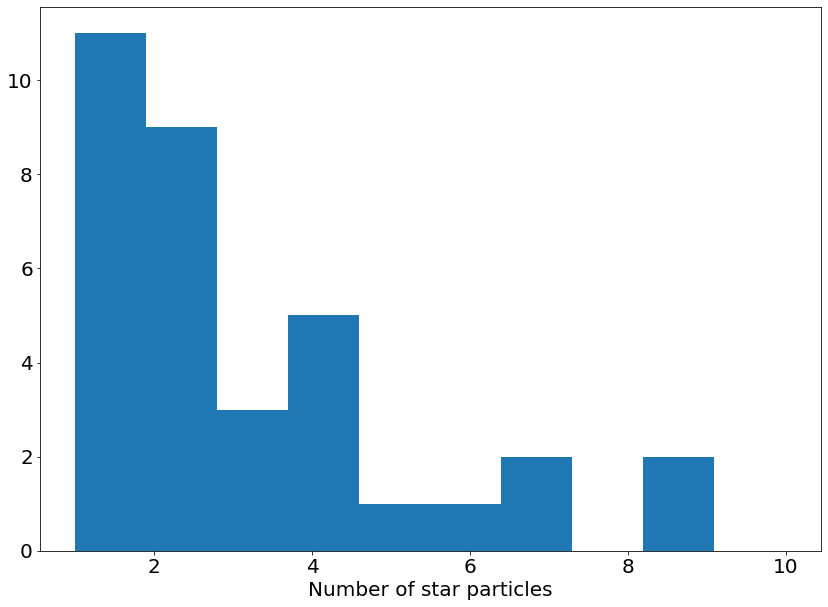

In [62]:
# ok, lets see this using 50 particles, thats low, i know. but firts histogram of particles number
pl.figure(figsize=(14, 10))

numberz0 = []

for n in numberlist:
    numberz0.append(n[0])

numberz0 = np.array(numberz0)
    
pl.hist(numberz0, range=(1,10), bins=10)

pl.xlabel('Number of star particles')

In [63]:
# ok, lets make the cut at n = 0
i10 = np.where(numberz0>10)

In [65]:
CosC, CosV = List['CosCen'], List['CosVel']
CosC10, CosV10 = CosC[i10], CosV[i10]
sat10, cen10 = List['SatelliteList'][i10], List['SatelliteCentral'][i10]

raddd10 = []

for ss, cc in zip(sat10, cen10):
    cenGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    cenBGG = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    grou = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    R200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][grou]
    
    dist = cenGal-cenBGG
    dd = np.sqrt(np.sum(dist**2.))
    dd = dd/R200
    
    raddd10.append(dd)
    
raddd10 = np.array(raddd10)

In [67]:
ir10 = np.where(raddd10>.5)

CosC10R, CosV10R = CosC10[ir10], CosV10[ir10]

In [68]:
# bootstrap!! because yes, bootstrap

n = 10000 # i guees is ok with that

dataCR = np.zeros((3,n))
dataVR = np.zeros((3,n))

dataC = np.zeros((3,n))
dataV = np.zeros((3,n))

for i in range(n):
    CosCR = np.random.choice(CosC10R, CosC10R.size)
    CosVR = np.random.choice(CosV10R, CosV10R.size)
    
    CosC = np.random.choice(CosC10, CosC10.size)
    CosV = np.random.choice(CosV10, CosV10.size)
    
    valueCR, edge, bbb = sps.binned_statistic(np.abs(CosCR), np.abs(CosCR), statistic='count', bins=3, range=(0.,1.))
    valueVR, edge, bbb = sps.binned_statistic(np.abs(CosVR), np.abs(CosVR), statistic='count', bins=3, range=(0.,1.))
    
    valueC, edge, bbb = sps.binned_statistic(np.abs(CosC), np.abs(CosC), statistic='count', bins=3, range=(0.,1.))
    valueV, edge, bbb = sps.binned_statistic(np.abs(CosV), np.abs(CosV), statistic='count', bins=3, range=(0.,1.))
    
    dataCR[:,i] = valueCR
    dataVR[:,i] = valueVR
    
    dataC[:,i] = valueC
    dataV[:,i] = valueV
    
valCR10 = np.array([np.mean(dataCR[0]), np.mean(dataCR[1]), np.mean(dataCR[2])])
errCR10 = np.array([np.std(dataCR[0]), np.std(dataCR[1]), np.std(dataCR[2])])

valVR10 = np.array([np.mean(dataVR[0]), np.mean(dataVR[1]), np.mean(dataVR[2])])
errVR10 = np.array([np.std(dataVR[0]), np.std(dataVR[1]), np.std(dataVR[2])])

valC10 = np.array([np.mean(dataC[0]), np.mean(dataC[1]), np.mean(dataC[2])])
errC10 = np.array([np.std(dataC[0]), np.std(dataC[1]), np.std(dataC[2])])

valV10 = np.array([np.mean(dataV[0]), np.mean(dataV[1]), np.mean(dataV[2])])
errV10 = np.array([np.std(dataV[0]), np.std(dataV[1]), np.std(dataV[2])])

xs = (edge[:-1]+edge[1:])*.5

In [70]:
cosRan10, cosRanV10 = [], []

for ss in zip(sat10[ir10]):
    cc, cv, crap = getAnglesRand(ss)
    cosRan10.append(cc)
    cosRanV10.append(cv)
    
cosRan10, cosRanV10 = np.array(cosRan10), np.array(cosRanV10)

<ipython-input-34-5046e591f208>:31: RuntimeWarning: invalid value encountered in true_divide
  LzL = Lz/L


In [71]:
# and boostrap this stuff

n = 10000 # i guees is ok with that

ranC10 = np.zeros((3,n))

for i in range(n):
    CosC1 = np.random.choice(cosRan10, cosRan10.size)
    
    valueC1, edge, bbb = sps.binned_statistic(np.abs(CosC1), np.abs(CosC1), statistic='count', bins=3, range=(0.,1.))
    
    ranC10[:,i] = valueC1
    
valRan10 = np.array([np.mean(ranC10[0]), np.mean(ranC10[1]), np.mean(ranC10[2])])
errRan10 = np.array([np.std(ranC10[0]), np.std(ranC10[1]), np.std(ranC10[2])])


Text(0, 0.5, 'number of galaxies')

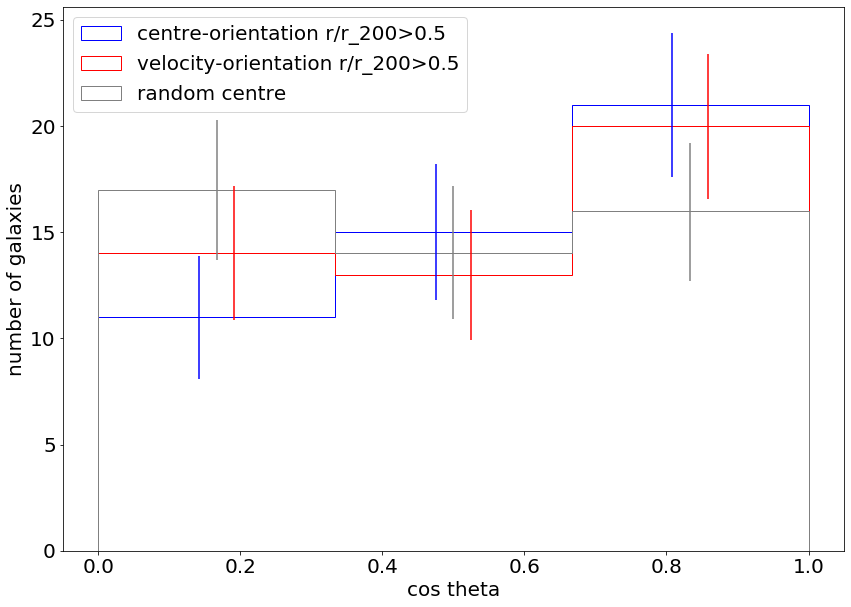

In [72]:
pl.figure(figsize=(14, 10))

pl.hist(np.abs(CosC10R), label='centre-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='blue')
pl.errorbar(xs-0.025, valCR10, yerr=errCR10, ls=' ', color='blue')

pl.hist(np.abs(CosV10R), label='velocity-orientation r/r_200>0.5', histtype='step', range=(0,1.), bins=3, color='red')
pl.errorbar(xs+0.025, valVR10, yerr=errVR10, ls=' ', color='red')

pl.hist(np.abs(cosRan10), label='random centre', histtype='step', range=(0,1.), bins=3, color='grey')
pl.errorbar(xs, valRan10, yerr=errRan10, ls=' ', color='grey')

pl.legend(loc=2)
pl.xlabel('cos theta')
pl.ylabel('number of galaxies')

In [73]:
# so, write these things.
# with h5py.File('SatelliteList_V2_withAngles_n10.h5', 'w') as f:
#     f.create_dataset('SatelliteList', data=List['SatelliteList'][i10])
#     f.create_dataset('SatelliteCentral', data=List['SatelliteCentral'][i10])
#     f.create_dataset('CosCen', data=List['CosCen'][i10])
#     f.create_dataset('CosVel', data=List['CosVel'][i10])
#     f.create_dataset('LZ_L', data=List['LZ_L'][i10])